In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py

from akita_utils.utils import ut_dense

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_map(matrix, vmin=-0.6, vmax=0.6, width=5, height=5, palette="RdBu_r"):

    """
    Plots a 512x512 map representating changes in the DNA contacts.

    Parameters
    ------------
    matrix : numpy array
        Changes in DNA contacts.
    vmin : float
    vmax : float
        Minimum and maximum in the colormap scale.
    width : int
    height : int
        Width and height of a plotted map.
    """

    fig = plt.figure(figsize=(width, height))

    sns.heatmap(
        matrix,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap=palette,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    plt.show()


In [3]:
def get_bin(
    window_start,
    window_end,
    map_size=512,
    bin_size=2048,
    input_size=1310720,
):

    """
    Returns a list of bins overlapping the given window.

    Parameters
    ------------
    window_start : int
    window_end : int
        Start and end of the window that overlapping bins we want to find.
        Note, those values are in the local coordinates, so between 0 and input_size.
    map_size : int
        Size of the maps (equivalent to number of bins).
    bin_size : int
        The length of each bin in base pairs (bp).
    input_size : int
        Length of model's input sequence.

    Returns
    ---------
    bin_index : int
        The bin overlapping the given window.
    """

    window_size = window_end - window_start

    size_after_cropping = map_size * bin_size
    size_difference = input_size - size_after_cropping
    one_side_cropped_length = size_difference // 2

    corrected_window_start = window_start - one_side_cropped_length
    corrected_window_end = window_end - one_side_cropped_length

    first_bin_covered = corrected_window_start // bin_size
    last_bin_covered = corrected_window_end // bin_size
    
    assert first_bin_covered == last_bin_covered
    
    return first_bin_covered
    

In [4]:
def get_insertion_start_pos(insert_bp, spacer_bp, num_inserts, seq_length = 1310720):

    insert_plus_spacer_bp = insert_bp + 2 * spacer_bp
    multi_insert_bp = num_inserts * insert_plus_spacer_bp
    insert_start_bp = seq_length // 2 - multi_insert_bp // 2

    insertion_starting_positions = []
    for i in range(num_inserts):
        offset = insert_start_bp + i * insert_plus_spacer_bp + spacer_bp
        insertion_starting_positions.append(offset)
        
    return insertion_starting_positions

In [5]:
def get_map_matrix(hf, num_sequences, head_index, model_index, num_background):
    """averaged over targets"""
    
    num_targets = 6
    if head_index != 1:
        num_targets = 5
    
    map_size = np.array(hf[f"e0_h{head_index}_m{model_index}_t0_b0"]).shape[0]
    
    map_matrix = np.zeros((map_size, map_size, num_sequences, num_background))

    for seq_index in range(num_sequences):
        for target_index in range(num_targets):
            for background_index in range(num_background):
                map_matrix[:, :, seq_index, background_index] += np.array(hf[f"e{seq_index}_h{head_index}_m{model_index}_t{target_index}_b{background_index}"])
    
    map_matrix = map_matrix / num_targets
    return map_matrix


In [ ]:
# hf = h5py.File("/home1/smaruj/akita_utils/bin/insert_virtual_dots_vs_boundaries/TEST/OUT.h5","r")

In [8]:
# reading h5 file with saved maps
hf = h5py.File("/home1/smaruj/akita_utils/bin/insert_virtual_dots_vs_boundaries/dots_25motifs/OUT.h5","r")

In [ ]:
# for key in hf:
#     print(key, hf[key].shape)

In [9]:
starts = get_insertion_start_pos(insert_bp=59, spacer_bp=99980, num_inserts=2)

In [10]:
insert_bp=59
row_line, col_line = get_bin(starts[0], starts[0]+insert_bp), get_bin(starts[1], starts[1]+insert_bp)

In [11]:
row_line, col_line

(207, 304)

In [12]:
num_sequences = 25
head_index = 1
model_index = 0
num_backgrounds = 1

In [13]:
map_matrix = get_map_matrix(hf, num_sequences, head_index, model_index, num_backgrounds)

Sequence 0


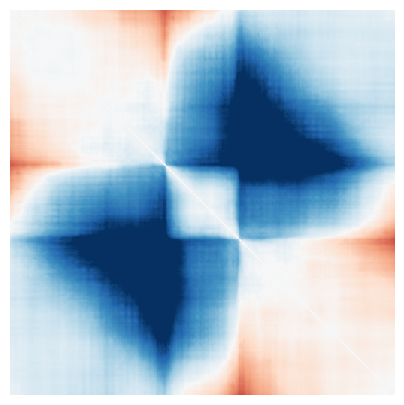

Sequence 1


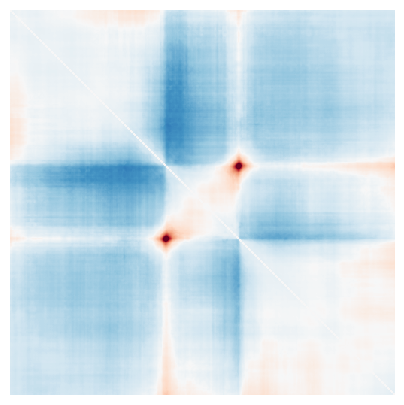

Sequence 2


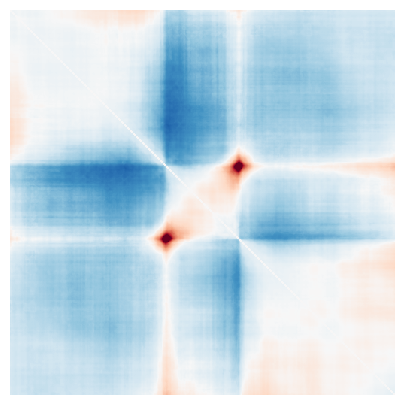

Sequence 3


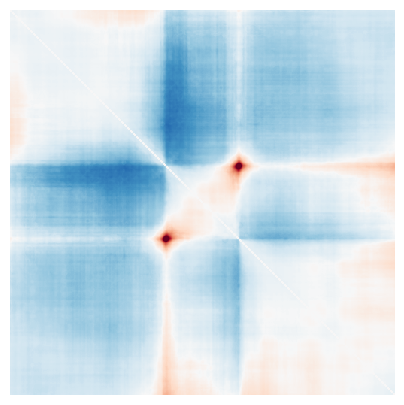

Sequence 4


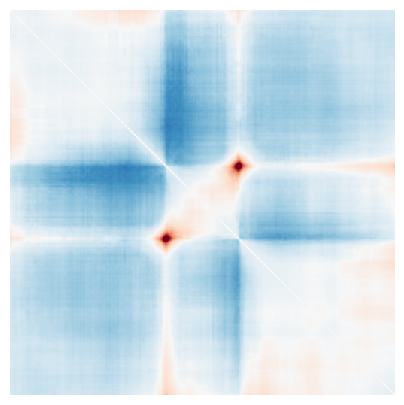

Sequence 5


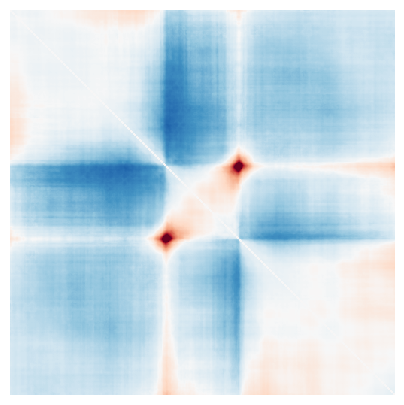

Sequence 6


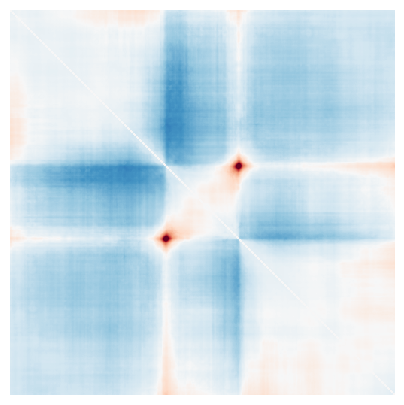

Sequence 7


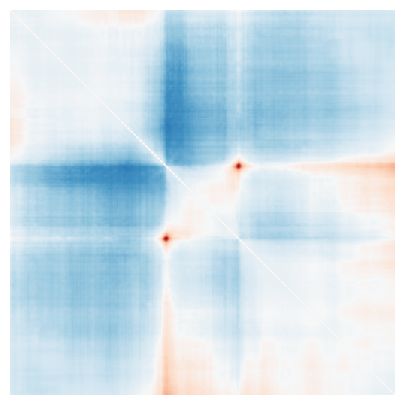

Sequence 8


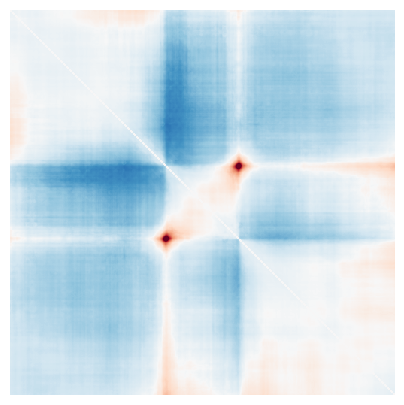

Sequence 9


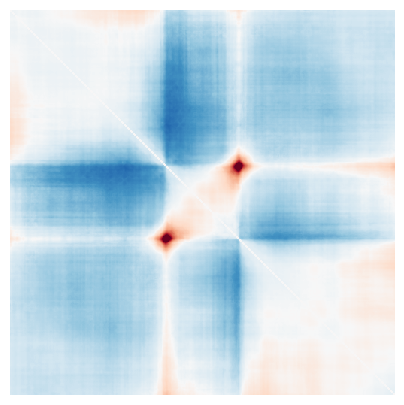

Sequence 10


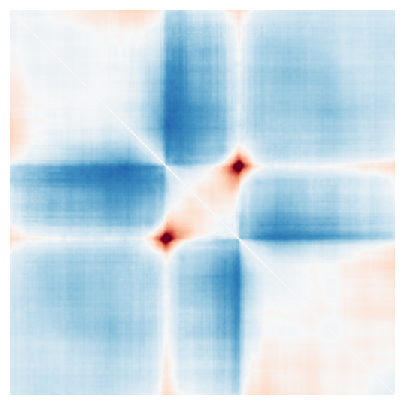

Sequence 11


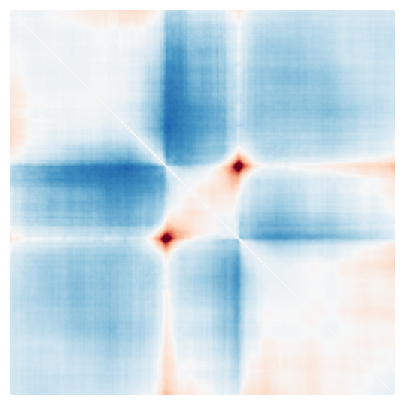

Sequence 12


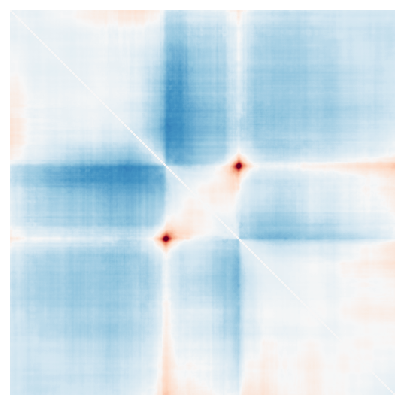

Sequence 13


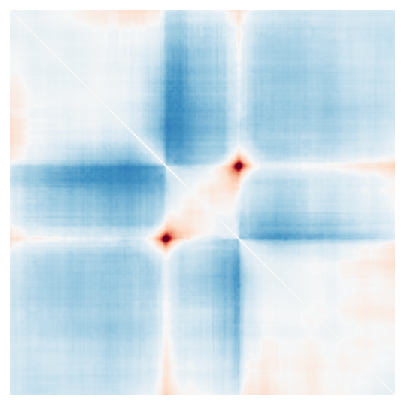

Sequence 14


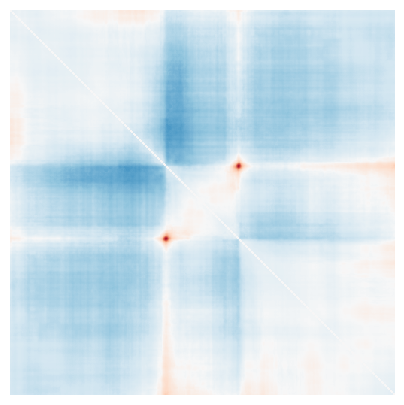

Sequence 15


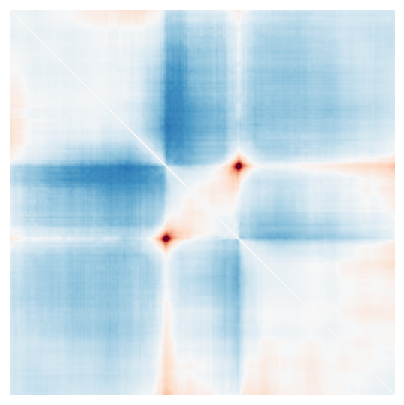

Sequence 16


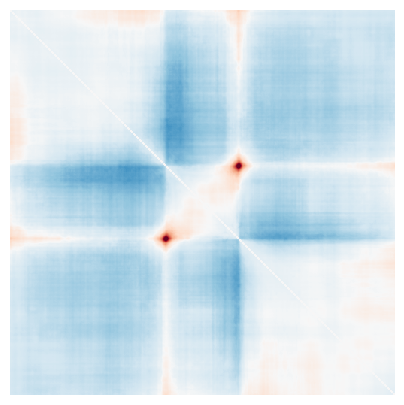

Sequence 17


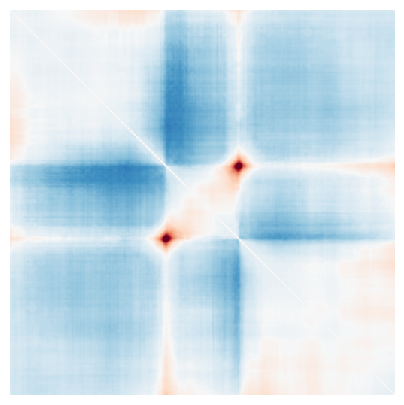

Sequence 18


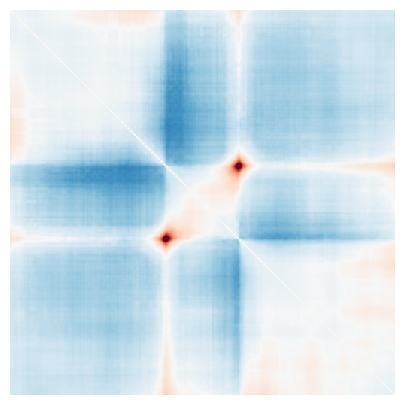

Sequence 19


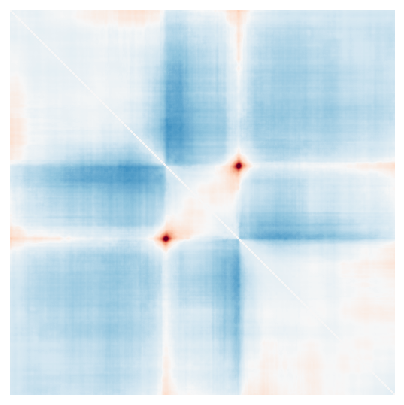

Sequence 20


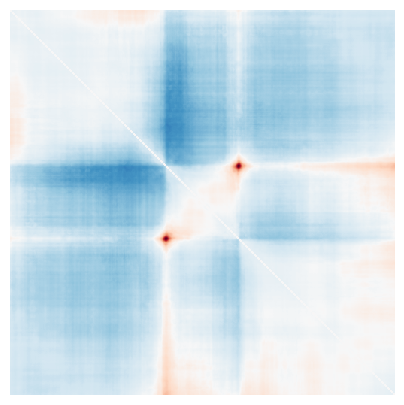

Sequence 21


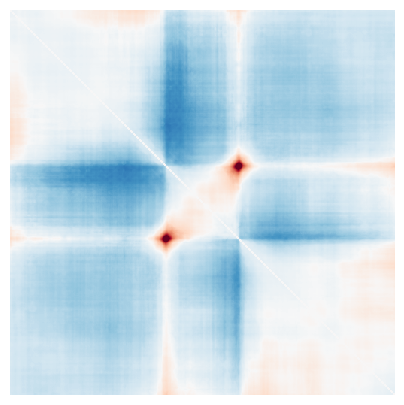

Sequence 22


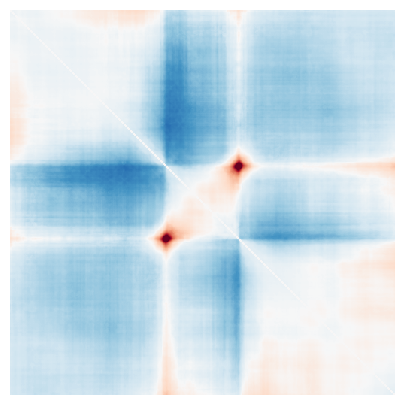

Sequence 23


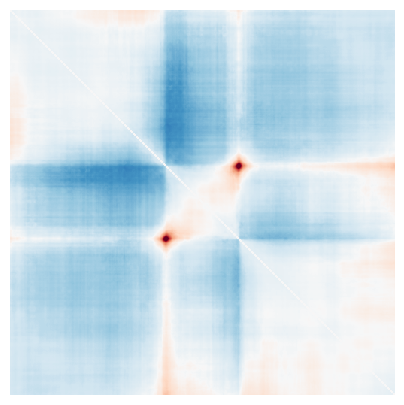

Sequence 24


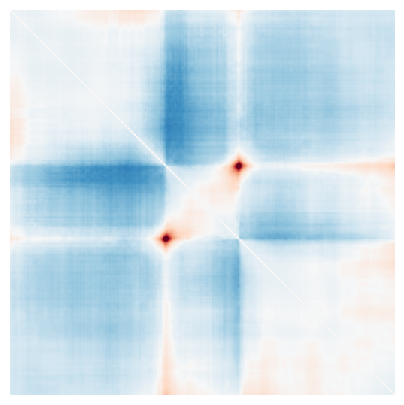

In [14]:
for seq_index in range(25):
    print(f"Sequence {seq_index}")
    plot_map(map_matrix[:, :, seq_index, 0])

In [34]:
for dot in [strong_dot, medium_dot, weak_dot]:
    print(dot_score_x(dot))

4.113032008113995
2.7108057114387756
1.465037692351237


In [15]:
halfsize = 15

In [16]:
strong_dot = map_matrix[row_line-halfsize: row_line+halfsize, col_line-halfsize:col_line+halfsize, 10, 0]

In [17]:
medium_dot = map_matrix[row_line-halfsize: row_line+halfsize, col_line-halfsize:col_line+halfsize, 24, 0]

In [18]:
weak_dot = map_matrix[row_line-halfsize: row_line+halfsize, col_line-halfsize:col_line+halfsize, 14, 0]

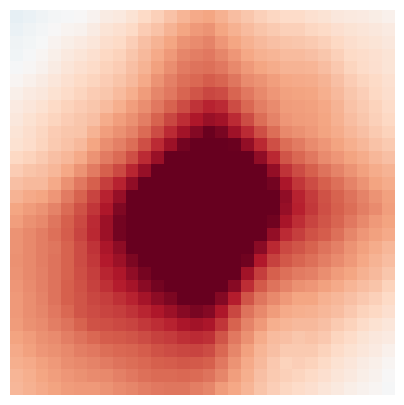

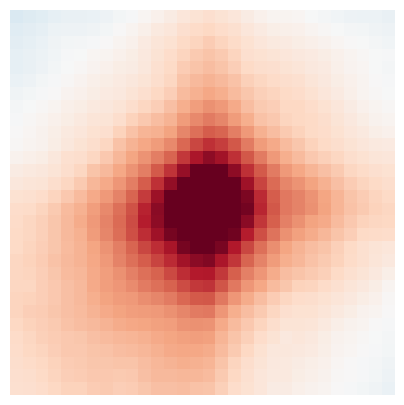

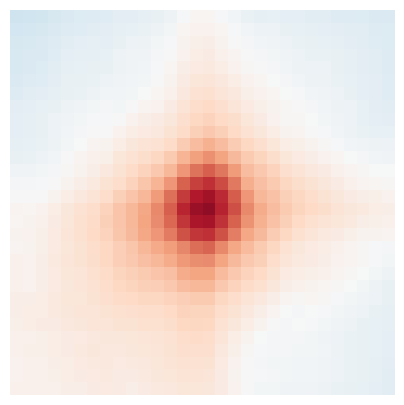

In [19]:
for dot in [strong_dot, medium_dot, weak_dot]:
    plot_map(dot)

In [20]:
def sum_squares(map_fragment):
    
    return np.sqrt((map_fragment**2).sum(axis=(0,1))) * (1/2)
    

In [21]:
def dot_alone(dot_matrix):
    
    # central, dot part
    dot_score = sum_squares(dot_matrix[10:20, 10:20])
    return dot_score

In [22]:
def dot_score_x(dot_matrix):
    
    # central, dot part
    dot_score = sum_squares(dot_matrix[10:20, 10:20])
    
    # x-parts
    x_score = 0
    for matrix_part in [dot_matrix[:10, :10], dot_matrix[:10, 20:], dot_matrix[20:, :10], dot_matrix[20:, 20:]]:
        x_score += sum_squares(matrix_part)
        
    return x_score / dot_score
    

In [23]:
def dot_score_cross(dot_matrix):
    
    # central, dot part
    dot_score = sum_squares(dot_matrix[10:20, 10:20])
    
    # cross-parts
    cross_score = 0
    for matrix_part in [dot_matrix[:10, 10:20], dot_matrix[10:20, :10], dot_matrix[10:20, 20:], dot_matrix[20:, 10:20]]:
        cross_score += sum_squares(matrix_part)
        
    return cross_score / dot_score

In [24]:
for dot in [strong_dot, medium_dot, weak_dot]:
    print(dot_alone(dot))

4.113032008113995
2.7108057114387756
1.465037692351237


In [25]:
for dot in [strong_dot, medium_dot, weak_dot]:
    print(dot_score_x(dot))

0.97951877011616
0.6906250692996275
0.7201777022705547


In [26]:
for dot in [strong_dot, medium_dot, weak_dot]:
    print(dot_score_cross(dot))

1.8057591657327547
1.521627137680314
1.1299066882636992


In [27]:
dot_scores_all = []

for seq_index in range(25):
    dot_matrix = map_matrix[row_line-halfsize: row_line+halfsize, col_line-halfsize:col_line+halfsize, seq_index, 0]
    dot_scores_all.append((seq_index, dot_score_cross(dot_matrix)))

Sequence:  0
Dot score:  3.8156784982483782


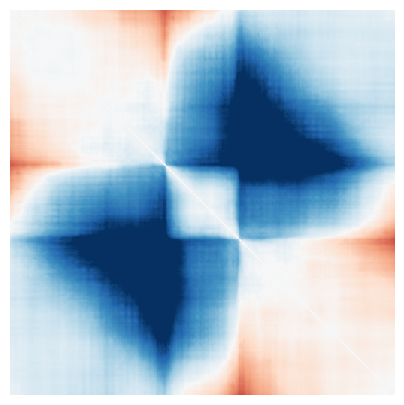

Sequence:  10
Dot score:  1.8057591657327547


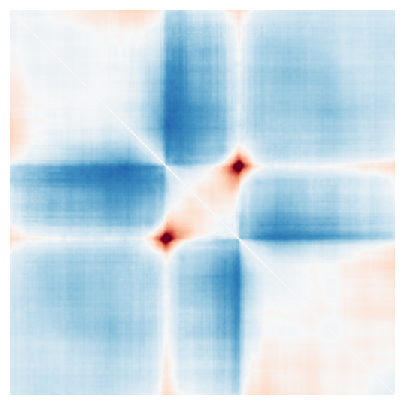

Sequence:  5
Dot score:  1.7315274747935065


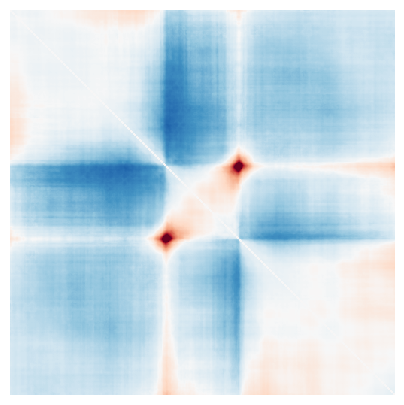

Sequence:  2
Dot score:  1.725420232026962


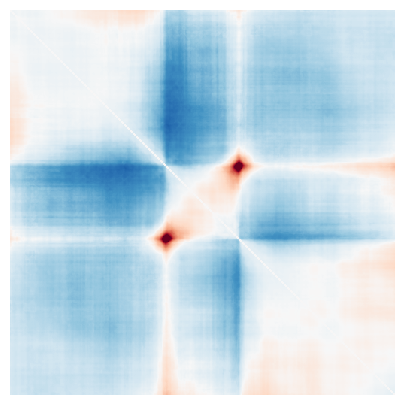

Sequence:  9
Dot score:  1.7103502481926063


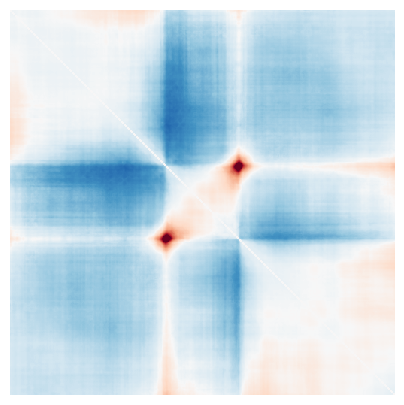

Sequence:  11
Dot score:  1.6801911943059793


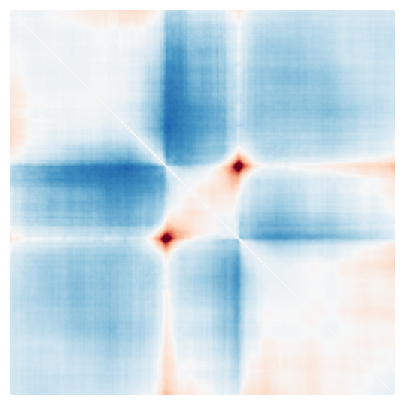

Sequence:  22
Dot score:  1.6519106072424625


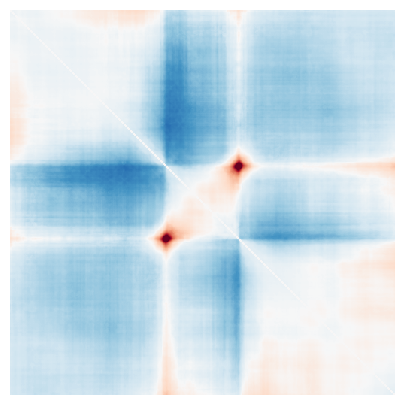

Sequence:  21
Dot score:  1.619717292777822


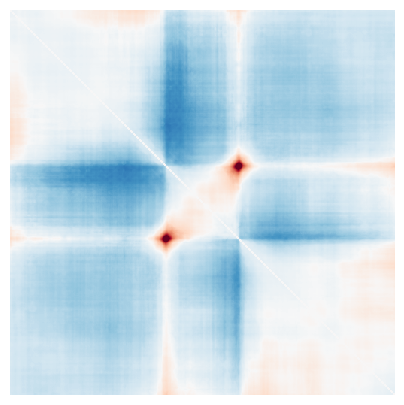

Sequence:  13
Dot score:  1.6029385066232822


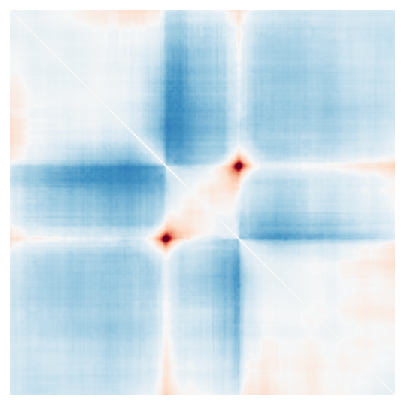

Sequence:  17
Dot score:  1.5970385229593793


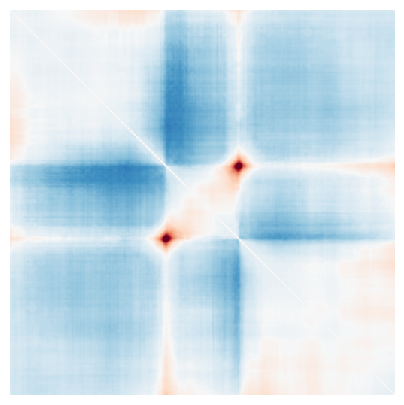

Sequence:  18
Dot score:  1.584376079625497


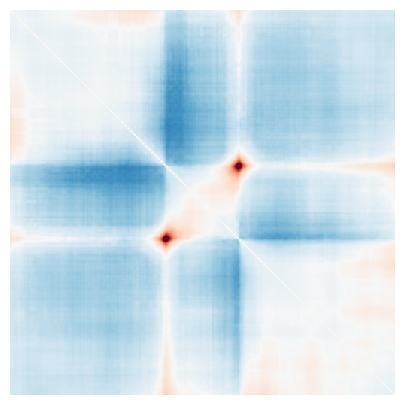

Sequence:  3
Dot score:  1.569735130394668


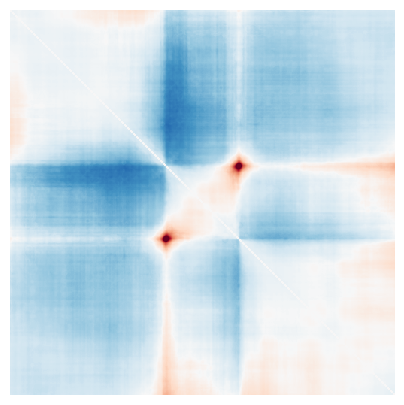

Sequence:  4
Dot score:  1.5696606010118093


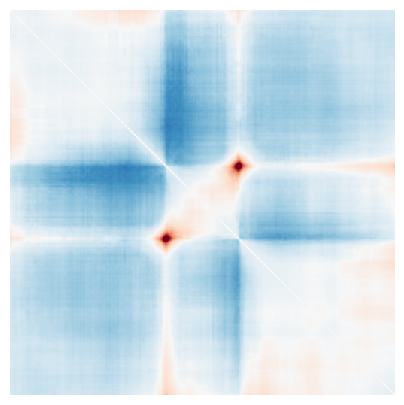

Sequence:  1
Dot score:  1.5396075536378657


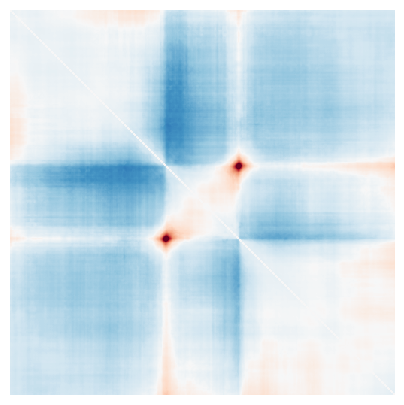

Sequence:  24
Dot score:  1.521627137680314


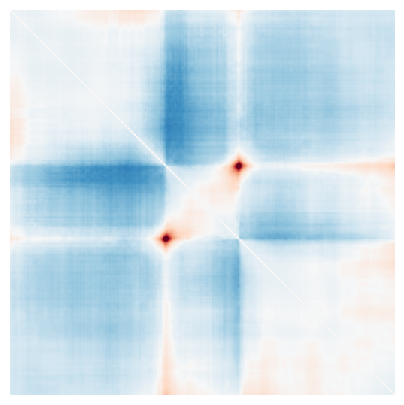

Sequence:  8
Dot score:  1.5160967245106114


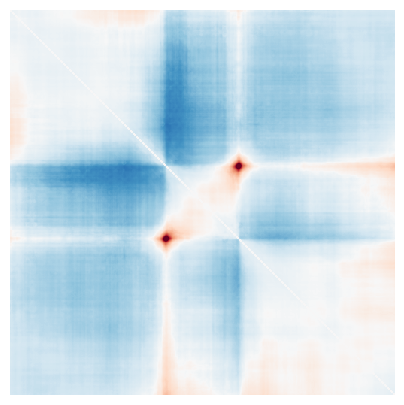

Sequence:  15
Dot score:  1.5045697068707704


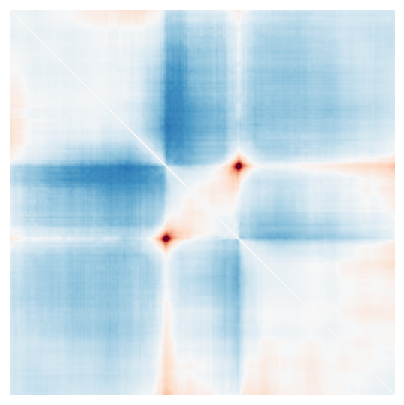

Sequence:  6
Dot score:  1.502372109199133


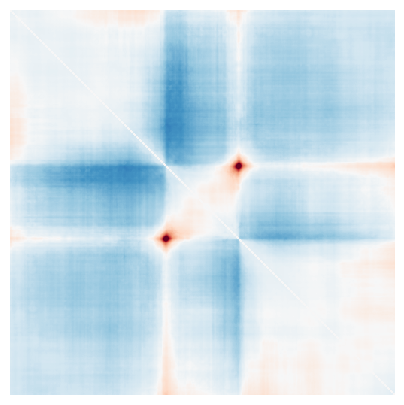

Sequence:  16
Dot score:  1.4719912561341557


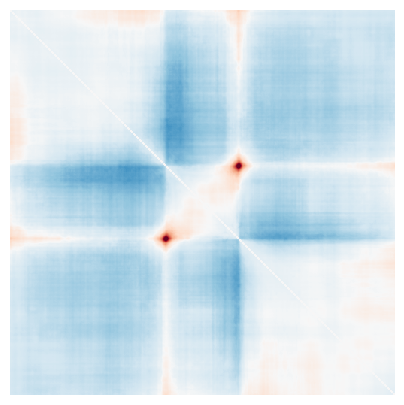

Sequence:  23
Dot score:  1.4714318839049483


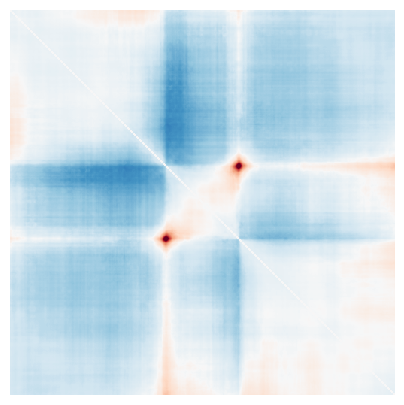

Sequence:  12
Dot score:  1.4575175251190673


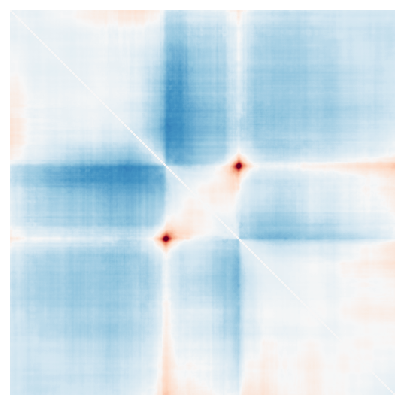

Sequence:  19
Dot score:  1.439098978962336


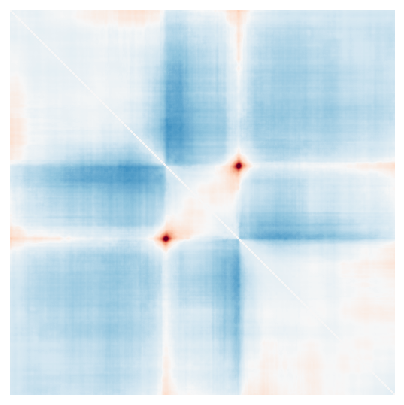

Sequence:  20
Dot score:  1.3055893798918805


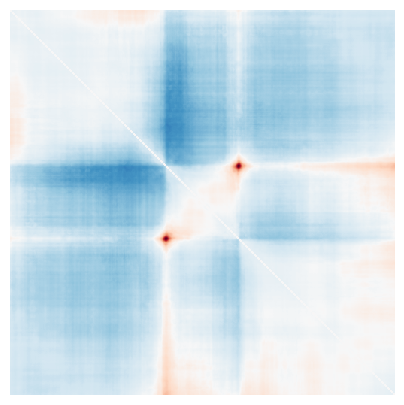

Sequence:  7
Dot score:  1.2005725811164236


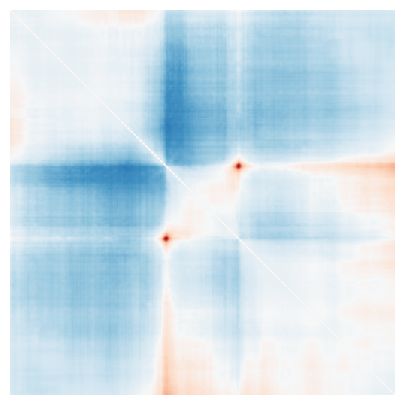

Sequence:  14
Dot score:  1.1299066882636992


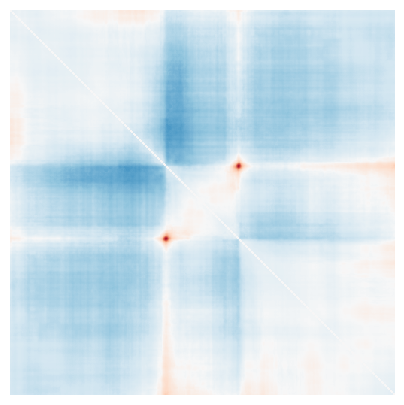

In [28]:
for seq_index, dot_score in sorted(dot_scores_all, key=lambda x:x[1], reverse=True):
    print("Sequence: ", seq_index)
    print("Dot score: ", dot_score)
    plot_map(map_matrix[:, :, seq_index, 0])